## imports and DB connection

In [7]:
import pandas as pd
import mysql.connector
import time
import os
import csv
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display
!pip install scipy pandas networkx matplotlib

%matplotlib inline


264.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Establishing connection to the ethereum database

In [8]:

# Database connection details
DB_HOST = '192.168.255.83'
DB_USER = 'moustafa.mahmoud'
DB_PASSWORD = '$*5f9fBvwzR!yf'
DB_NAME = 'eth' 

db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_NAME
)


# PART 1 : DATASET CREATION

### database queries 

In [3]:

def get_address_id(address_hash):
    cursor = db_connection.cursor(dictionary=True)
    query = "SELECT id FROM address WHERE hash = %s"
    cursor.execute(query, (address_hash,))
    result = cursor.fetchone()
    cursor.close()
    return result['id'] if result else None

def get_address_hash(address_id):
    cursor = db_connection.cursor(dictionary=True)
    query = "SELECT hash FROM address WHERE id = %s"
    cursor.execute(query, (address_id,))
    result = cursor.fetchone()
    cursor.close()
    return result['hash'] if result else None

def get_erc20_transactions(address_id):
    """
    columns for this query :
    id hash tx_index gas_price_in_wei gas_used block_id block_timestamp total_eth_transfer total_deployment total_erc20_transfer type status base_fee max_fee priority_fee input reverse_hash total_erc721_transfer total_internal_transfer input output tx_id index_in_tx contract_id crypto_amount
    """

    cursor = db_connection.cursor(dictionary=True)
    # Query for getting all erc20 transaction 
    query = """
        SELECT * 
        FROM transaction t 
        JOIN address_address_erc20_transaction atx ON t.id = atx.tx_id 
        WHERE atx.output = %s OR atx.input = %s
        ORDER BY t.block_timestamp ASC 
    """
    cursor.execute(query, (address_id,address_id))
    results = cursor.fetchall()
    cursor.close()
    return results

def get_eth_transactions(address_id):
    """
    columns for this query :
    id hash tx_index gas_price_in_wei gas_used block_id block_timestamp total_eth_transfer total_deployment total_erc20_transfer type status base_fee max_fee priority_fee input reverse_hash total_erc721_transfer total_internal_transfer input output tx_id crypto_amount
    """

    cursor = db_connection.cursor(dictionary=True)
    # Query for getting eth transactions
    query = """
        SELECT * 
        FROM transaction t 
        JOIN address_address_transaction atx ON t.id = atx.tx_id 
        WHERE atx.output = %s OR atx.input = %s
        ORDER BY t.block_timestamp ASC 
    """

    cursor.execute(query, (address_id,address_id))
    results = cursor.fetchall()
    cursor.close()
    return results



### Helper functions to better manage writing the dataset into csvs 

In [4]:
def write_checkpoint(index):
    with open(CHECKPOINT_FILE, 'w') as f:
        f.write(str(index))

def read_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            return int(f.read().strip())
    return 0

def print_progress(index, total, num_transactions, address):
    progress = (index / total) * 100
    print(f"Processing address {index + 1}/{total} ({progress:.2f}%), Address: {address}, Transactions: {num_transactions}")


### output files

In [39]:
# Output files
OUTPUT_FILE = 'transaction_metadata.csv'
CHECKPOINT_FILE = 'checkpoint.txt'


### Genereating the single csv dataset of all the erc20 trascations for an address flagged as an address poisining address

In [36]:
# Load the CSV file
df = pd.read_csv('address_poisoning.csv')

# Get the last processed index
last_index = read_checkpoint()

# Total number of addresses
total_addresses = len(df)

# Open the output file in append mode
with open(OUTPUT_FILE, 'a') as output_file:
    # Write headers if the file is empty
    if os.path.getsize(OUTPUT_FILE) == 0:
        headers = ['from', 'to', 'hash', 'tx_index', 'gas_price_in_wei', 'gas_used', 'block_id', 'block_timestamp', 'total_eth_transfer', 'total_deployment', 'total_erc20_transfer', 'status', 'base_fee', 'max_fee', 'priority_fee', 'input', 'reverse_hash', 'total_erc721_transfer', 'total_internal_transfer', 'index_in_tx', 'contract_id', 'crypto_amount', 'type']
        output_file.write(','.join(headers) + '\n')

    # Iterate over each row
    for index in range(last_index, total_addresses):
        row = df.iloc[index]
        address = row['Address']
        currency = row['Currency']
        
        if currency == 'ETH':
            address_id = get_address_id(address)
            if address_id:
                erc20_transactions = get_erc20_transactions(address_id)
                eth_transactions = get_eth_transactions(address_id)
                transactions = erc20_transactions + eth_transactions
                num_transactions = len(transactions)
                print_progress(index, total_addresses, num_transactions, address)
                for tx in transactions:
                    tx_metadata = {
                        'from': address if tx['input'] == address_id else get_address_hash(tx['input']),
                        'to': address if tx['output'] == address_id else get_address_hash(tx['output']),
                        'hash': tx['hash'],
                        'tx_index': tx['tx_index'],
                        'gas_price_in_wei': tx['gas_price_in_wei'],
                        'gas_used': tx['gas_used'],
                        'block_id': tx['block_id'],
                        'block_timestamp': tx['block_timestamp'],
                        'total_eth_transfer': tx['total_eth_transfer'],
                        'total_deployment': tx['total_deployment'],
                        'total_erc20_transfer': tx['total_erc20_transfer'],
                        'status': tx['status'],
                        'base_fee': tx['base_fee'],
                        'max_fee': tx['max_fee'],
                        'priority_fee': tx['priority_fee'],
                        'input': tx['input'],
                        'reverse_hash': tx['reverse_hash'],
                        'total_erc721_transfer': tx['total_erc721_transfer'],
                        'total_internal_transfer': tx['total_internal_transfer'],
                        'index_in_tx': tx['index_in_tx'] if tx in erc20_transactions else None,
                        'contract_id': tx['contract_id'] if tx in erc20_transactions else None,
                        'crypto_amount': tx['crypto_amount'],
                        "type": 'erc20' if tx in erc20_transactions else 'eth'
                    }

                    # Write the transaction metadata to the output file
                    output_file.write(','.join(map(str, tx_metadata.values())) + '\n')
            else:
                print_progress(index, total_addresses, 0, address)
        else:
            print_progress(index, total_addresses, 0, address)

        # Write the checkpoint after each iteration
        write_checkpoint(index)
    
        # Sleep to avoid overwhelming the database
        time.sleep(0.1)

print("Processing complete.")


Processing complete.


### Genereating a single csv dataset of all the erc20 trascations for an address not flagged as an address poisining address

In [6]:
def get_latest_n_transaction():
    cursor = db_connection.cursor(dictionary=True)
    query = "SELECT hash FROM `address` ORDER BY `address`.`id` DESC LIMIT 3000;"
    cursor.execute(query)
    result = cursor.fetchone()
    cursor.close()
    return result['hash'] if result else None


def write_transactions_to_csv(transactions, filename="filtered_transactions.csv"):
    # Open the CSV file in write mode
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(["Address", "Currency"])
        # Write the transactions
        for address in transactions:
            writer.writerow([address, "ETH"])


filtered_transactions = get_latest_n_transaction()
write_transactions_to_csv(filtered_transactions)


# filtered_transactions = filter_transactions(3000)

# def filter_transactions(limit):
#     # Read the poisoned addresses from the CSV file
#     poisoned_addresses = set()
#     with open('address_poisoning.csv', mode='r') as file:
#         reader = csv.DictReader(file)
#         for row in reader:
#             poisoned_addresses.add(row['Address'])

#     # Get the latest transactions using the provided function
#     latest_transactions = []
#     txs = get_latest_n_transaction(3000)
#     for tx in txs:
#         if tx not in poisoned_addresses:
#             latest_transactions.append(tx)
#         left_out_count = limit - len(latest_transactions)
#         print(f"{left_out_count} entries were left out of the {limit} limit.")

#     return latest_transactions



InternalError: Unread result found

## Constructing the transaction graph based dataset

### Define input and output file paths


In [49]:
# Load your CSV file
file = pd.read_csv('dataset/transaction_metadata.csv')

# Add a 'class' column with value 1
file['class'] = 1

# Save the updated DataFrame to a new CSV file
file.to_csv('dataset/transaction_metadata_with_class.csv', index=False)

print("Class column added successfully!")


/home/moustafa-mahmoud/.virtualenvs/address_poisoning_dataset-Hfv8_GC8/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (12,13,14,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Class column added successfully!


In [9]:
input_csv = 'dataset/transaction_metadata_with_class.csv'
nodes_csv = 'dataset/nodes.csv'
edges_csv = 'dataset/edges.csv'
checkpoint_file = 'trasnaction_graph_checkpoint.txt'


### Initialize checkpoints


In [7]:
def read_checkpoint():
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'r') as file:
            return int(file.readline().strip())
    return 0

def write_checkpoint(last_processed_row):
    with open(checkpoint_file, 'w') as file:
        file.write(str(last_processed_row))


### Initialize CSV files if not already present


In [5]:
def initialize_csv_files():
    if not os.path.exists(nodes_csv):
        with open(nodes_csv, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['address'])

    if not os.path.exists(edges_csv):
        with open(edges_csv, 'w', newline='') as file:
            writer = csv.writer(file)
            # Write headers (same as input CSV except 'from' and 'to' replaced by 'source' and 'target')
            writer.writerow([
                'source', 'target', 'hash', 'tx_index', 'gas_price_in_wei', 
                'gas_used', 'block_id', 'block_timestamp', 'total_eth_transfer', 
                'total_deployment', 'total_erc20_transfer', 'status', 'base_fee', 
                'max_fee', 'priority_fee', 'input', 'reverse_hash', 'total_erc721_transfer', 
                'total_internal_transfer', 'index_in_tx', 'contract_id', 'crypto_amount', 'type'
            ])


### Append new rows to Nodes and Edges CSV files

In [11]:
def process_transactions(start_index):
    nodes_set = set()  # To track unique addresses
    last_processed_row = start_index

    with open(input_csv, 'r') as infile, \
         open(nodes_csv, 'a', newline='') as nodes_outfile, \
         open(edges_csv, 'a', newline='') as edges_outfile:

        reader = csv.DictReader(infile)
        nodes_writer = csv.writer(nodes_outfile)
        edges_writer = csv.writer(edges_outfile)

        for index, row in enumerate(reader):
            if index < start_index:
                continue

            # Update last processed row
            last_processed_row = index + 1

            # Extract source and target addresses
            source = row['from']
            target = row['to']

            # Add addresses to the Nodes CSV if they are not already present
            if source not in nodes_set:
                nodes_writer.writerow([source])
                nodes_set.add(source)

            if target not in nodes_set:
                nodes_writer.writerow([target])
                nodes_set.add(target)

            # Write the transaction data to the Edges CSV
            edges_writer.writerow([
                source, target, row['hash'], row['tx_index'], row['gas_price_in_wei'], 
                row['gas_used'], row['block_id'], row['block_timestamp'], row['total_eth_transfer'], 
                row['total_deployment'], row['total_erc20_transfer'], row['status'], row['base_fee'], 
                row['max_fee'], row['priority_fee'], row['input'], row['reverse_hash'], 
                row['total_erc721_transfer'], row['total_internal_transfer'], row['index_in_tx'], 
                row['contract_id'], row['crypto_amount'], row['type']
            ])

            # Periodically update the checkpoint
            if index % 100 == 0:  # Adjust this number as needed
                write_checkpoint(last_processed_row)

    # Final checkpoint update
    write_checkpoint(last_processed_row)


In [12]:
    # Initialize CSV files if needed
    initialize_csv_files()

    # Read the last processed row from the checkpoint
    start_index = read_checkpoint()

    # Process the transactions starting from the last checkpoint
    process_transactions(start_index)


## Visualize the dataset


### Load Data

In [10]:
input_df = pd.read_csv(input_csv)
nodes_df = pd.read_csv(nodes_csv)
edges_df = pd.read_csv(edges_csv)


/home/moustafa-mahmoud/.virtualenvs/address_poisoning_dataset-Hfv8_GC8/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
# Function to visualize a small sample of the CSV data
def visualize_data_table(input_df, sample_size=10, title="Sample of Input CSV Data"):
    sample_df = input_df.head(sample_size)
    display(sample_df)



visualize_data_table(input_df)
visualize_data_table(nodes_df)
visualize_data_table(edges_df)

,from,to,hash,tx_index,gas_price_in_wei,gas_used,block_id,block_timestamp,total_eth_transfer,total_deployment,...,priority_fee,input,reverse_hash,total_erc721_transfer,total_internal_transfer,index_in_tx,contract_id,crypto_amount,type,class
0,0x4e5b2e1dc63f6b91cb6cd759936495434c7e972f,0xf9a55bae633213a4c283bac774e766357d86d9a6,0x5c882ccd71f00ce881610c3252a9d750ec1dda08503e...,69,38000000000,21000,18668579,1701155819,1,0,...,0,47227150,0913d0572f42236bd1c1e30580add1ce057d9a2523c016...,0,0,None,None,197104000000000000.0,eth,1
1,0xf9a55bae633213a4c283bac774e766357d86d9a6,0x18d88d253ded3f2c52937a081536697697669025,0x52241247656d851301242d1f3faa81484029ad8b1ac5...,69,29771233875,359666,18670143,1701174743,0,1,...,1000000000,285049725,cc2654c39f100fd0ddc25ca1b8da92048418aaf3f1d242...,0,0,None,None,0.0,eth,1
2,0xf9a55bae633213a4c283bac774e766357d86d9a6,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x4b3f040c5397df6978394522f927fc312fa69b0ed45f...,48,40450120072,21000,18681698,1701314399,1,0,...,0,285049725,db8dec57771cbda64119f54de0b96af213cf729f225493...,0,0,None,None,185546846875602240.0,eth,1
3,0x111111125421ca6dc452d289314280a0f8842a65,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x3e9d3fa814f83ff4aab5344439a838882d4a74276279...,140,27329864495,169801,19525509,1711540703,3,0,...,4850000,294399623,86a1d9898f7284217e5597267247a4d288838a9344435b...,0,2,3,45676948,6915.08385,erc20,1
4,0x808a05462b648ae72451347c9a5f4e75cc16be62,0xdf0770df86a8034b3efef0a1bb3c889b8332ff56,0xa4d78141fad025229d9de36ab0ed3992d9eb2123dc3a...,248,27350588836,372077,19525548,1711541171,4,0,...,84681000,285243032,719a82288430fcab3a87a3cd3212be9d2993de0ba63ed9...,0,3,0,45676948,6915.08385,erc20,1
5,0xf9a55bae633213a4c283bac774e766357d86d9a6,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x4b3f040c5397df6978394522f927fc312fa69b0ed45f...,48,40450120072,21000,18681698,1701314399,1,0,...,0,285049725,db8dec57771cbda64119f54de0b96af213cf729f225493...,0,0,None,None,185546846875602240.0,eth,1
6,0xd0ccf523d198a9e0ef6222ad3d3e3f1919898725,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x378c29c4dd7d9bae50f32bbaae74d4e211e9824280b7...,47,40450120072,21000,18681698,1701314399,1,0,...,0,285049330,495bc0310a344ffc70e77b0824289e112e4d47eaabb23f...,0,0,None,None,173208569975300032.0,eth,1
7,0x52836874a60b2e0a025e250e36a1cf87706d7586,0x808a05462b648ae72451347c9a5f4e75cc16be62,0xb9f655319a2adb4cd7bbb43a4f5d074eb3038b0ab8ba...,43,31052120199,21000,18683169,1701332135,1,0,...,0,284845184,33f64d1a9498a0b0bd2dab8ba0b8303be470d5f4a34bbb...,0,0,None,None,15452408475564982.0,eth,1
8,0x4a98561c965dad79e4915a814d8df0362d492c99,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x75727e9af536c8fc64dcfeb11c2ef9ad9ada48541562...,73,23831767409,21000,18944494,1704499367,1,0,...,0,285879965,323af89071534100a53e26514584ada9da9fe2c11befcd...,0,0,None,None,30942435103770216.0,eth,1
9,0xb5551a2bd3d79a89555a15e45c3b420b6147bfef,0x808a05462b648ae72451347c9a5f4e75cc16be62,0x2196afac62b16ae4c8212aa027955f52cf325cf5d9d1...,72,23831767409,21000,18944494,1704499367,1,0,...,0,286126833,8383d2c5e45b4e21f6791d9d5fc523fc25f559720aa212...,0,0,None,None,15404409426743966.0,eth,1


,address
0,0x74faa20f5559863a0faaeef1debedaff603bb4c1
1,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d
2,0x95a47681c6cf915f2fc994d810cd886f2c1ff990
3,0x2ebb7731f0b64393d98cbc636cede05f6bf5473c
4,0x124f5cece888e4054a932121f7ef1e79bd0c0abf
5,0xbee2817ea289534b5089bf2554362b064e974ba7
6,0xe5f683794193671b5904c5ca1636278ffe29f3c0
7,0x3b0303e4a30649d6da5eaa9deef7963bb1d0d8b0
8,0x96a7f9d3f2a1fb59ad95a14c05219fa274a9a2dd
9,0x323c27af91641d0369a7033587065dd0696f17fb


,source,target,hash,tx_index,gas_price_in_wei,gas_used,block_id,block_timestamp,total_eth_transfer,total_deployment,...,max_fee,priority_fee,input,reverse_hash,total_erc721_transfer,total_internal_transfer,index_in_tx,contract_id,crypto_amount,type
0,0x74faa20f5559863a0faaeef1debedaff603bb4c1,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0x3d4a3173c2551e2073795384f8f696f6a4d9ee91b773...,34,7021894157,58739,18361578,1697442911,0,0,...,22870373984,1500000000,96851148,143dcd12e1f5d6ee72b9377b19ee9d4a6f696f8f483597...,0,0,2,280447931,2.000000e+09,erc20
1,0x95a47681c6cf915f2fc994d810cd886f2c1ff990,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0xbdcd814b9e1f113961ea97b89c4c1ec85d4dc8708df1...,66,11320652317,2606131,18363679,1697468243,0,0,...,39578143852,1500000000,269682418,c314d34644fcbd4415571fd8078cd4d58ce1c4c98b79ae...,0,0,221,280447931,5.000000e+09,erc20
2,0x2ebb7731f0b64393d98cbc636cede05f6bf5473c,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0x1ab4db7eb09d2da2db519756022b9d503c1a8bc63463...,8,24099240891,2612131,18364074,1697473007,0,0,...,94542159796,1500000000,15316386,a6fa6d20d9e1a75ab1d036436cb8a1c305d9b220657915...,0,0,88,280536852,1.200000e+09,erc20
3,0x124f5cece888e4054a932121f7ef1e79bd0c0abf,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0x6e351fb8500049a8f1e546613ba03f44e07de0805d5c...,4,24591526634,2607259,18364078,1697473055,0,0,...,95077858336,1500000000,225941266,0b1565795cda8f4ee6cdc5d5080ed70e44f30ab316645e...,0,0,266,280536852,1.000000e+09,erc20
4,0xbee2817ea289534b5089bf2554362b064e974ba7,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0x9d1ff2c0af50bc6e8c830a8af40c908fd4ee1e5d2739...,24,8377556616,38925,18375586,1697612063,0,0,...,31953235956,1500000000,274363793,55f7a816c2e09208eca39372d5e1ee4df809c04fa8a038...,0,0,1,280690624,7.000000e+09,erc20
5,0xe5f683794193671b5904c5ca1636278ffe29f3c0,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0xbc8f1f4983d6b3ad80450ae13e29749b010c572d9229...,45,8393334942,38937,18376167,1697619107,0,0,...,30558964556,1500000000,213388725,c6c362f121482c0b18de9229d275c010b94792e31ea054...,0,0,0,280738815,3.000000e+02,erc20
6,0x3b0303e4a30649d6da5eaa9deef7963bb1d0d8b0,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0x010f35589816ed3990cc1bb5d1b6dfd5db052e69db83...,49,11965968036,48546,18379444,1697658779,0,0,...,45227547036,1500000000,258011117,f01c6f2d9d7417bd0b2938bd96e250bd5dfd6b1d5bb1cc...,0,0,1,280738815,3.000000e+04,erc20
7,0x74faa20f5559863a0faaeef1debedaff603bb4c1,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0xc8e1ae9b9412db99d23a3b3e95d46d2ba579394a20a9...,54,7427648000,38913,18384014,1697714123,0,0,...,27692399456,1500000000,96851148,ff0529d91b53dc7b5ee59a02a493975ab2d64d59e3b3a3...,0,0,0,280811050,2.000000e+03,erc20
8,0x95a47681c6cf915f2fc994d810cd886f2c1ff990,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0xcda9ef13cc1f9c317a2366ced5ab53b956c691134471...,88,8176479171,63275,18389918,1697785307,0,0,...,29522706012,1500000000,269682418,28870dbe1bfce28dd7e9174431196c659b35ba5dec6632...,0,0,3,280925941,5.000000e+03,erc20
9,0x3b0303e4a30649d6da5eaa9deef7963bb1d0d8b0,0x09f4e0ee9c1544e6115b9240af047f6dbc37e85d,0xe5b483a74e18d41942df476b14d01f1c36a4379d825c...,63,12380373293,49166,18390557,1697793071,0,0,...,45158998996,1500000000,258011117,228ac0cfe2a720fce385c528d9734a63c1f10d41b674fd...,0,0,0,280964496,3.000000e+04,erc20


### Function to visualize the graph


In [13]:
def visualize_graph(edges_df, nodes_df=None, title="Transaction Graph"):
    G = nx.DiGraph()  # Create a directed graph

    # Add nodes 
    if nodes_df is not None:
        for index, row in nodes_df.iterrows():
            G.add_node(row['address'])

    # Add edges
    for index, row in edges_df.iterrows():
        G.add_edge(row['source'], row['target'], **row.to_dict())

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)  # Positioning of nodes
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", arrows=True, arrowsize=20)
    plt.title(title)
    plt.show()


### Visualize the graph using the Edges and Nodes CSV files


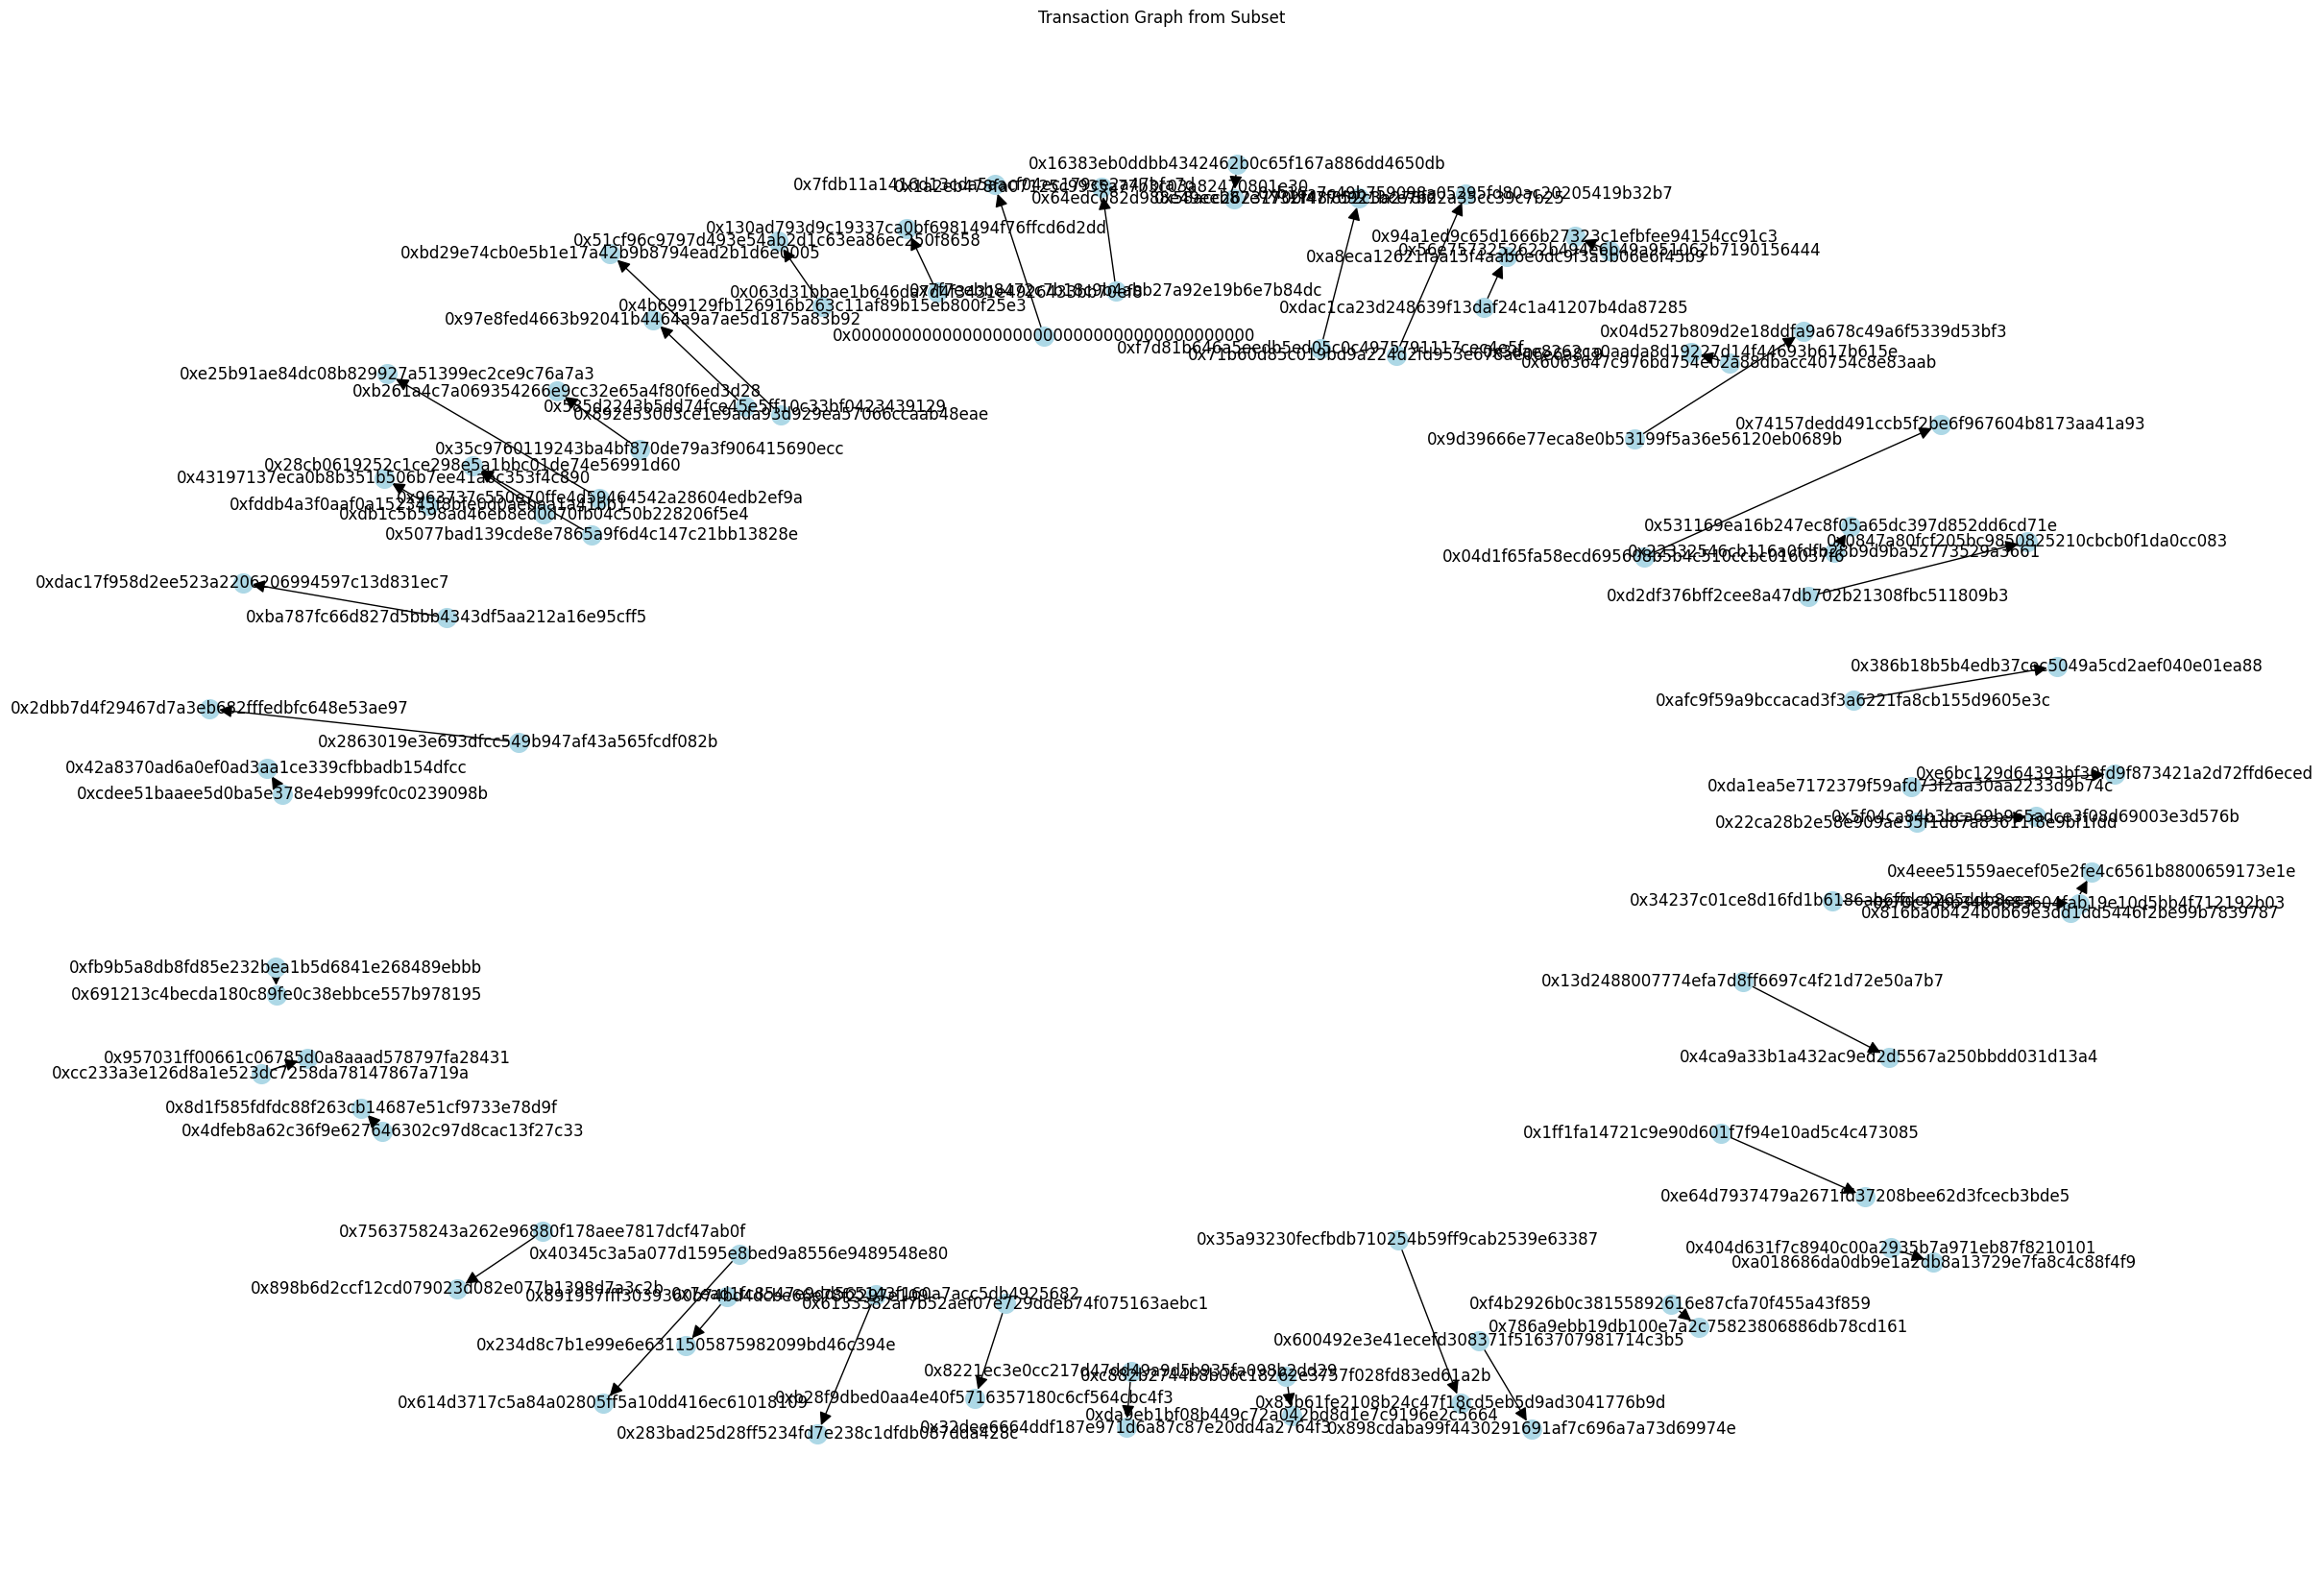

In [22]:
def visualize_graph_subset(edges_df, nodes_df=None, title="Transaction Graph from Subset", sample_size=100):
    G = nx.DiGraph()  

    edges_sample_df = edges_df.sample(n=sample_size)


    if nodes_df is not None:
        sampled_nodes = set(edges_sample_df['source']).union(set(edges_sample_df['target']))
        for node in sampled_nodes:
            G.add_node(node)


    for index, row in edges_sample_df.iterrows():
        G.add_edge(row['source'], row['target'], **row.to_dict())

    # Draw the graph
    plt.figure(figsize=(24, 16))
    pos = nx.spring_layout(G)  
    nx.draw(G, pos, with_labels=True, node_size=200, node_color="lightblue", arrows=True, arrowsize=20)
    plt.title(title)
    plt.show()


visualize_graph_subset(edges_df, nodes_df, title="Transaction Graph from Subset", sample_size=50)
